# Predicción del precio de casas de Boston

Intentaremos predecir el precio mediano de las viviendas en un barrio de Boston a mediados de la década de 1970, partiendo de una variedad de datos sobre el el barrio en el momento, como la tasa de criminalidad, la tasa de impuesto a la propiedad, etc.

El conjunto de datos que usaremos es pequeña, 506 muestras en total. Debemos estar atentos, ya que hay valores discretos y continuos (como la criminalidad).

Los datos contienen 13 características a partir de las cuales deberíamos ser capaces de poder predecir el precio de cada vivienda. Las características son:

1. Ratio de crimen per cápita.

2. Proporción de tierra residencial dividida en zonas de más de 25.000 pies cuadrados.
3. Proporción de acres de negocios no minoristas por ciudad.
4. Variable ficticia de Charles River (= 1 si limita con el río; 0 en caso contrario).
5. Concentración de óxidos nítricos (partes por 10 millones).
6. Número promedio de habitaciones por vivienda.
7. Proporción de unidades ocupadas por sus propietarios y construídas antes de 1940.
8. Distancias ponderadas a cinco centros de empleo de Boston.
9. Índice de accesibilidad a carreteras radiales.
10. Tasa de impuesto a la propiedad de valor total por $10,000.
11. Relación alumno-profesor por localidad.
12. 1000 * (Bk - 0.63) ** 2 donde Bk es la proporción de personas negras por pueblo.
13. % de población de un estatus bajo.

In [1]:
! pip install analytics-zoo
! sudo apt install openjdk-8-jdk
! echo "2" | sudo update-alternatives --config java

     |████████████████████████████████| 186.1MB 57kB/s 
     |████████████████████████████████| 215.6MB 71kB/s 
     |████████████████████████████████| 104.0MB 40kB/s 
     |████████████████████████████████| 204kB 51.8MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.3-py2.py3-none-any.whl size=215964963 sha256=4feedac62d0892e6abf7c658cb16150ff6830828a20c1d8112c975444674f1ab
  Stored in directory: /root/.cache/pip/wheels/8d/20/f0/b30e2024226dc112e256930dd2cd4f06d00ab053c86278dcf3
Successfully built pyspark
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-

In [2]:
from zoo.common.nncontext import *
sc = init_nncontext(init_spark_conf().setMaster("local[4]"))

Prepending /usr/local/lib/python3.6/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /usr/local/lib/python3.6/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.10.0-spark_2.4.3-0.8.1-jar-with-dependencies.jar to BIGDL_JARS
Prepending /usr/local/lib/python3.6/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


In [5]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.2.0


In [0]:
from zoo.pipeline.api.keras.datasets import boston_housing
(train_data, train_labels), (test_data, test_labels) =  boston_housing.load_data()
# Shuffle the training set
order = np.argsort(np.random.random(train_targets.shape))
train_data = train_data[order]
train_labels = train_labels[order]

In [31]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (404, 13)
Testing set:  (102, 13)


In [32]:
print(train_data[0])

[  0.79041   0.        9.9       0.        0.544     6.122    52.8
   2.6403    4.      304.       18.4     396.9       5.98   ]


In [33]:
import pandas as pd

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.79041,0.0,9.90,0.0,0.5440,6.122,52.8,2.6403,4.0,304.0,18.4,396.90,5.98
1,0.21038,20.0,3.33,0.0,0.4429,6.812,32.2,4.1007,5.0,216.0,14.9,396.90,4.85
2,0.03427,0.0,5.19,0.0,0.5150,5.869,46.3,5.2311,5.0,224.0,20.2,396.90,9.80
3,22.59710,0.0,18.10,0.0,0.7000,5.000,89.5,1.5184,24.0,666.0,20.2,396.90,31.99
4,14.43830,0.0,18.10,0.0,0.5970,6.852,100.0,1.4655,24.0,666.0,20.2,179.36,19.78


In [35]:
print(train_labels[0:10])  # Display first 10 entries

[22.1 35.1 19.5  7.4 27.5 17.1 34.6 15.  50.  16.1]


In [36]:
# Test data is *not* used when calculating the mean and std.

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-0.32184493 -0.48917404 -0.18117892 -0.27288841 -0.07955171 -0.21384194
 -0.55672959 -0.55013096 -0.63664704 -0.6244493  -0.01527164  0.44592354
 -0.94202322]


In [37]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, 
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.compat.v1.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

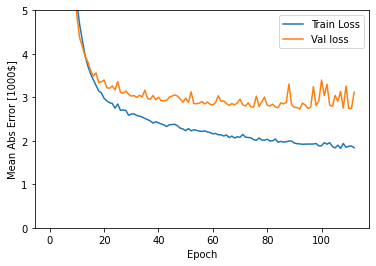

In [49]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mae']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,5])

plot_history(history)


....................................................................................................
..................................

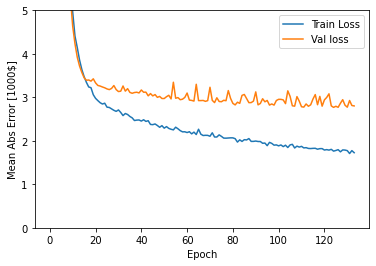

In [50]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [51]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2325.88


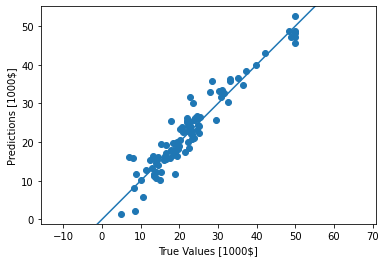

In [52]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100],[-100,100])

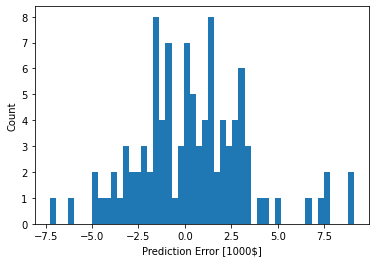

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
_ = plt.ylabel("Count")